In [ ]:
sc

# ================================
# READ TO CSV FROM HDFS VIA SPARK
# ================================

In [1]:
%%time
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("HDFSToCSV").getOrCreate()

# Read CSV file with Spark DataFrame
df = spark.read.csv("/ProjectTweets.csv", header=False, inferSchema=True)

CPU times: user 7.99 ms, sys: 1.48 ms, total: 9.47 ms
Wall time: 22.6 s


In [ ]:
# Show DataFrame First 5 Rows
df.show(5)

In [ ]:
df.printSchema()

In [2]:
# The first method for renamed the column names
# df = df.withColumnRenamed("_c0", "id").withColumnRenamed("_c1", "stamp").withColumnRenamed("_c2", "date").withColumnRenamed("_c3", "flag").withColumnRenamed("_c4", "user").withColumnRenamed("_c5", "text")

# The second method for renamed the column names
df = df.selectExpr("_c0 as ID", "_c1 as STAMP", "_c2 as DATE", "_c3 as FLAG", "_c4 as USER", "_c5 as TEXT")
df.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
| ID|     STAMP|                DATE|    FLAG|           USER|                TEXT|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



In [ ]:
# How many rows does the dataframe 
row_count = df.count()
# Print row_count
print("DataFrame has {} rows.".format(row_count))

In [ ]:
from pyspark.sql.functions import col

columns = ["ID", "STAMP", "DATE", "FLAG", "USER", "TEXT"]

Columns = df.columns

# Check out the each column and Count unique values
for column in Columns:
    unique_values = df.select(column).distinct()
    unique_count = unique_values.count()
    
    if unique_count > 0:
        print(f"{column} has {unique_count} unique values:")
    else:
        print(f"{column} has no unique value.")

In [ ]:
from pyspark.sql.functions import col

columns = ["ID", "STAMP", "DATE", "FLAG", "USER", "TEXT"]

Columns = df.columns

# Check out the each column and Count duplicate values
for column in Columns:
    count_df = df.groupBy(column).count()
    duplicate_values = count_df.filter(col("count") > 1).count()
    
    if duplicate_values > 0:
        print(f"{column} has {duplicate_values} duplicate values.")
    else:
        print(f"{column} has no duplicate value.")

In [3]:
# Drop the selected columns
df = df.drop("ID", "STAMP", "FLAG", "USER")
df.show(5)

+--------------------+--------------------+
|                DATE|                TEXT|
+--------------------+--------------------+
|Mon Apr 06 22:19:...|@switchfoot http:...|
|Mon Apr 06 22:19:...|is upset that he ...|
|Mon Apr 06 22:19:...|@Kenichan I dived...|
|Mon Apr 06 22:19:...|my whole body fee...|
|Mon Apr 06 22:19:...|@nationwideclass ...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df.describe().show()

In [ ]:
df.summary().show()

In [ ]:
from pyspark.sql.functions import col

# Do a grouping and counting operation to find duplicate values in the "TEXT" column
count_df = df.groupBy("TEXT").count()

# Filter rows containing duplicate values
duplicate_values = count_df.filter(col("count") > 1)

# If there are duplicate values, show them
if duplicate_values.count() > 0:
    print("Duplicate values:")
    duplicate_values.show(truncate=False)  # Display column values in full length
else:
    print("No duplicate values found.")

In [ ]:
# How many rows does the dataframe 
row_count = df.count()
# Print row_count
print("DataFrame has {} rows.".format(row_count))

In [ ]:
df.printSchema()

# =====================
# TEXT PRE-PROCESSING
# =====================

In [4]:
from pyspark.sql.functions import col, udf, lower, regexp_replace
from pyspark.sql.types import ArrayType, StringType, FloatType

import string
import nltk
import re
import contractions
import torch

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer 

from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import word_tokenize

In [ ]:
df.select("TEXT").show(3, truncate=False)

#### TEXT CLEANING

In [5]:
import re

# Cleaning Function
def clean_text(text):
    text = text.strip()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s\s+', ' ', text)
    text = re.sub(r'[@_!#$%^&*()<>?/\|}{~:]', '', text)
    text = text.lower()
    return text

# Save as UDF
clean_text_udf = udf(clean_text, StringType())

# Create new column
df = df.withColumn("TEXT_C1", clean_text_udf(col("text")))
df.select("TEXT", "TEXT_C1").show(3, truncate=False)

+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+
|TEXT                                                                                                               |TEXT_C1                                                                                                      |
+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D| - a that's a bummer. you shoulda got david carr of third day to do it. ;d                                   |
|is upset that he can't update his Facebook by texting it... and might cry as a result  

#### EXPAND CONTRACTIONS

In [6]:
import contractions

# Function to expand contractions
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

# Save as UDF
expand_contractions_udf = udf(expand_contractions, StringType())

# Use the UDF and Create new column
df = df.withColumn("TEXT_C2", expand_contractions_udf(col("TEXT_C1")))

# Show the dataframe
df.select("TEXT", "TEXT_C1", "TEXT_C2").show(3, truncate=False)

+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------+
|TEXT                                                                                                               |TEXT_C1                                                                                                      |TEXT_C2                                                                                                       |
+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------

#### CLEAN THE PUNCTUATION CHARACTERS

In [7]:
# Define punctuation characters
punctuation_characters = r'[!\"#\$%&\'\(\)\*\+,\-./:;<=>\?@[\\]\^_`{|}~]'

# Remove punctuation characters
df = df.withColumn("TEXT_C3", regexp_replace(col("TEXT_C2"), punctuation_characters, ""))

# Show the dataframe
df.select("TEXT", "TEXT_C1", "TEXT_C2", "TEXT_C3").show(3, truncate=False)

+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+
|TEXT                                                                                                               |TEXT_C1                                                                                                      |TEXT_C2                                                                                                       |TEXT_C3                                                                                                   |
+-----------------------------------------------------------------------------------------------------------

#### CLEAN THE STOPWORDS

In [8]:
# Download "stopwords" from nltk dictionary
nltk.download("stopwords")

# Configure the language as english
stop_words = set(stopwords.words("english"))

# Define the udf 
remove_stopwords_udf = udf(lambda text: " ".join([word for word in text.split() if word not in stop_words]), StringType())

# Use the UDF in order to remove stopwords and Create new column
df = df.withColumn("TEXT_C4", remove_stopwords_udf(col("TEXT_C3")))

# Show the dataframe
df.select("TEXT", "TEXT_C1", "TEXT_C2", "TEXT_C3", "TEXT_C4").show(3, truncate=False)

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------+
|TEXT                                                                                                               |TEXT_C1                                                                                                      |TEXT_C2                                                                                                       |TEXT_C3                                                                                                   |TEXT_C4                         

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


#### IMPLEMENT LEMMATIZATION

In [9]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download 'punkt','averaged_perceptron_tagger','wordnet' from nltk dictionary
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Defining the function that implements the Lemmatization operation as a UDF
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    words = word_tokenize(text)
    for w in words:
        lemma = lemmatizer.lemmatize(w)
        lemmatized_sentence.append(lemma)
    lemmatized_text = " ".join(lemmatized_sentence)
    return lemmatized_text

# Define the UDF
lemmatize_text_udf = udf(lemmatize_text, StringType())

# Use the UDF and Create new column
df = df.withColumn("TEXT_C5", lemmatize_text_udf(df["TEXT_C4"]))

# Show the dataframe
df.select("TEXT", "TEXT_C1", "TEXT_C2", "TEXT_C3", "TEXT_C4", "TEXT_C5").show(3, truncate=False)

[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hduser/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/hduser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------+-----------------------------------------------------------------------------+
|TEXT                                                                                                               |TEXT_C1                                                                                                      |TEXT_C2                                                                                                       |TEXT_C3                                                      

#### IMPLEMENT STEMMING

In [10]:
from nltk.stem import SnowballStemmer

# Defining the function that finds word roots as UDF 
def stem_text(text):
    snow = SnowballStemmer('english')
    stemmed_sentence = []
    words = word_tokenize(text)
    for w in words:
        stemmed_sentence.append(snow.stem(w))
    stemmed_text = " ".join(stemmed_sentence)
    return stemmed_text

# Define the UDF
stem_text_udf = udf(stem_text, StringType())

# Use the UDF and Create new column
df = df.withColumn("TEXT_C6", stem_text_udf(df["TEXT_C5"]))

# Show the dataframe
df.select("TEXT", "TEXT_C1", "TEXT_C2", "TEXT_C3", "TEXT_C4", "TEXT_C5", "TEXT_C6").show(3, truncate=False)

+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------+-----------------------------------------------------------------------------+-------------------------------------------------------------------------+
|TEXT                                                                                                               |TEXT_C1                                                                                                      |TEXT_C2                                                                                           

#### IMPLEMENT TOKENIZATION

In [11]:
from pyspark.sql.types import ArrayType, StringType
from nltk.tokenize import word_tokenize

# Function that splits text into tokens using NLTK
def tokenize_text(text):
    words = word_tokenize(text)
    return words

# Define the UDF
tokenize_text_udf = udf(tokenize_text, ArrayType(StringType()))

# Use the UDF and Create new column
df = df.withColumn("TOKENS", tokenize_text_udf(df["TEXT_C6"]))

# Show the selected dataframe
df.select("TEXT", "TEXT_C6", "TOKENS").show(3, truncate=False)

+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------+---------------------------------------------------------------------------------------+
|TEXT                                                                                                               |TEXT_C6                                                                  |TOKENS                                                                                 |
+-------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------+---------------------------------------------------------------------------------------+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|bummer shoulda got david carr third day    

#### DROP THE REDUNDANT COLUMNS

In [12]:
df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                DATE|                TEXT|             TEXT_C1|             TEXT_C2|             TEXT_C3|             TEXT_C4|             TEXT_C5|             TEXT_C6|              TOKENS|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Mon Apr 06 22:19:...|@switchfoot http:...| - a that's a bum...| - a that is a bu...|  a that is a bum...|bummer shoulda go...|bummer shoulda go...|bummer shoulda go...|[bummer, shoulda,...|
|Mon Apr 06 22:19:...|is upset that he ...|is upset that he ...|is upset that he ...|is upset that he ...|upset cannot upda...|upset can not upd...|upset can not upd...|[upset, can, not,...|
|Mon Apr 06 22:19:...|@Kenichan I dived...| i

In [13]:
# Drop the selected columns
df = df.drop("TEXT_C1", "TEXT_C2", "TEXT_C3", "TEXT_C4", "TEXT_C5")
df.show(5)

+--------------------+--------------------+--------------------+--------------------+
|                DATE|                TEXT|             TEXT_C6|              TOKENS|
+--------------------+--------------------+--------------------+--------------------+
|Mon Apr 06 22:19:...|@switchfoot http:...|bummer shoulda go...|[bummer, shoulda,...|
|Mon Apr 06 22:19:...|is upset that he ...|upset can not upd...|[upset, can, not,...|
|Mon Apr 06 22:19:...|@Kenichan I dived...|dive mani time ba...|[dive, mani, time...|
|Mon Apr 06 22:19:...|my whole body fee...|whole bodi feel i...|[whole, bodi, fee...|
|Mon Apr 06 22:19:...|@nationwideclass ...|behav mad can not...|[behav, mad, can,...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



#### IMPLEMENT TOKENIZATION AND SPLIT WORDS TO ROWS

In [14]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import explode, col

# Create The Tokenizer
tokenizer = Tokenizer(inputCol="TEXT_C6", outputCol="words")
tokenizer_df = tokenizer.transform(df)

# Separate words into individual lines
tokenizer_df = tokenizer_df.select(explode(col("words")).alias("word"))

# Show the dataframe
tokenizer_df.show(3, truncate=False)

+-------+
|word   |
+-------+
|bummer |
|shoulda|
|got    |
+-------+
only showing top 3 rows



Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


#### Table 1: Count The Tokenizer Words

In [15]:
%%time
# Count the tokenizer words
tokenizer_df_count = tokenizer_df.groupBy("word").count().orderBy("count", ascending=False)

# Show the dataframe
tokenizer_df_count.show(50)

+--------+------+
|    word| count|
+--------+------+
|      go|166567|
|     get|110081|
|     day|104229|
|    good| 90642|
|    work| 85247|
|    love| 83670|
|    like| 82996|
|    want| 73530|
|     got| 70192|
|   today| 66116|
|     can| 65276|
|     not| 65174|
|    time| 64442|
|   thank| 60681|
|    know| 58235|
|    miss| 56632|
|    back| 56412|
|     one| 55924|
|     lol| 55410|
|     see| 50993|
|    feel| 50662|
|   think| 50636|
|  realli| 50066|
|    hope| 43761|
|   night| 43625|
|   watch| 43128|
|    need| 42919|
|   still| 42858|
|   would| 42622|
|    make| 42565|
|     new| 42006|
|    well| 41080|
|     amp| 40799|
|    home| 39506|
|    look| 39101|
|    come| 38630|
|      oh| 38139|
|    much| 36645|
|    last| 35770|
| twitter| 34457|
|tomorrow| 34448|
|    morn| 34275|
|    wish| 33245|
|   great| 33174|
|    wait| 32002|
|     sad| 31545|
|   sleep| 31232|
|  though| 31021|
|    haha| 30358|
|     way| 29580|
+--------+------+
only showing top 50 rows

CP

#### Figure 1: WordCloud The Tokenizer Words

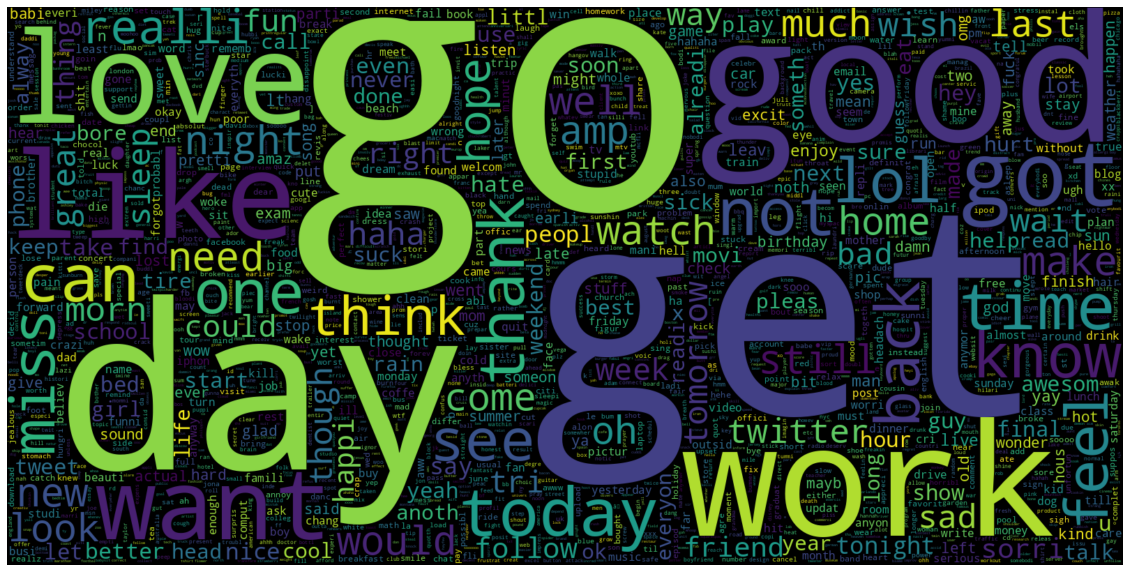

In [16]:
%%time
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert the Spark DataFrame to Pandas DataFrame
pandas_df_count = tokenizer_df_count.toPandas()

# Create a dictionary from the Pandas DataFrame for word frequencies
word_freq_dict = dict(zip(pandas_df_count['word'], pandas_df_count['count']))

# Generate WordCloud for positive sentiments
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800).generate_from_frequencies(word_freq_dict)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## ==============
## Text Blob Method
## ==============
#### SENTIMENT SCORES AND SENTIMENT LABEL

In [17]:
%%time

from textblob import TextBlob

# Sentimental Analysis Function
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Sentiment Label Function
def label_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

#=========================================================================================#

from pyspark.sql.types import FloatType, StringType

# Define the UDF with Functions
sentiment_udf = udf(get_sentiment, FloatType())
label_udf = udf(label_sentiment, StringType())

# Use the UDF and Create new columns
df = df.withColumn('SentimentScores', sentiment_udf(df['TEXT_C6']))
df = df.withColumn('SentimentLabels', label_udf(df['SentimentScores']))

# Show the Selected Columns
df.select("TEXT_C6", "SentimentLabels", "SentimentScores").show(truncate=False)

CPU times: user 19.1 s, sys: 427 ms, total: 19.5 s
Wall time: 37min 21s


+---------------+------+
|SentimentLabels| count|
+---------------+------+
|       positive|582277|
|        neutral|782253|
|       negative|235470|
+---------------+------+

CPU times: user 110 ms, sys: 33.8 ms, total: 144 ms
Wall time: 25min 35s


#### TABLE 2: SENTIMENT LABEL COUNT ( POSITIVE - NEGATIVE - NEUTRAL )

In [ ]:
# Count and Show the 'sentiment_label' column
df.groupBy('SentimentLabels').count().show()

## ==================
## Vader Lexicon Method
## ==================
#### SENTIMENT SCORES

In [18]:
%%time

from nltk import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk.download('punkt')

# Define a function
def filter_sentiment_words(text):
    sia = SentimentIntensityAnalyzer()
    words = word_tokenize(text)
    filtered_words = [word for word in words if sia.polarity_scores(word)['compound'] != 0]
    return filtered_words

# Define the UDF to get the sentiment score
filter_sentiment_udf = udf(filter_sentiment_words, ArrayType(StringType()))
sentiment_score_udf = udf(lambda text: SentimentIntensityAnalyzer().polarity_scores(text)['compound'], FloatType())

# Apply the UDFs to the 'TEXT_C6' column
df = df.withColumn("SentimentWords", filter_sentiment_udf(col("TEXT_C6")))
df = df.withColumn("NewSentimentScores", sentiment_score_udf(col("TEXT_C6")))

# Show the Selected Columns
df.select("TEXT_C6", "SentimentWords", "NewSentimentScores").show(truncate=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hduser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


+----------------------------+-----------------------+------------------+
|DATE                        |SentimentWords         |NewSentimentScores|
+----------------------------+-----------------------+------------------+
|Mon Apr 06 22:19:45 PDT 2009|[bummer]               |-0.3818           |
|Mon Apr 06 22:19:49 PDT 2009|[upset, blah]          |-0.4588           |
|Mon Apr 06 22:19:53 PDT 2009|[save]                 |0.4939            |
|Mon Apr 06 22:19:57 PDT 2009|[like, fire]           |0.0258            |
|Mon Apr 06 22:19:57 PDT 2009|[mad]                  |-0.4939           |
|Mon Apr 06 22:20:00 PDT 2009|[]                     |0.0               |
|Mon Apr 06 22:20:03 PDT 2009|[hug]                  |0.4767            |
|Mon Apr 06 22:20:03 PDT 2009|[yes, lol, fine, thank]|0.8316            |
|Mon Apr 06 22:20:05 PDT 2009|[]                     |0.0               |
|Mon Apr 06 22:20:09 PDT 2009|[]                     |0.0               |
|Mon Apr 06 22:20:16 PDT 2009|[]      

#### TABLE 3: NEW SENTIMENT LABEL COUNT ( POSITIVE - NEGATIVE - NEUTRAL )

In [ ]:
%%time

# Sentiment Label Function
def new_label_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# Define the UDF with Function
new_label_udf = udf(new_label_sentiment, StringType())

# Use the UDF and Create new column
df = df.withColumn('NewSentimentLabels', new_label_udf(df['NewSentimentScores']))

# Count and Show the 'NewSentimentLabels' column
df.groupBy('NewSentimentLabels').count().show()

## Sentiment Score Comparison of TextBlob and Vader Methods 

In [19]:
df.select("TEXT", "SentimentScores", "NewSentimentScores").show(50, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------+---------------+------------------+
|TEXT                                                                                                                                      |SentimentScores|NewSentimentScores|
+------------------------------------------------------------------------------------------------------------------------------------------+---------------+------------------+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D                       |0.0            |-0.3818           |
|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!                           |0.0            |-0.4588           |
|@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                              

#### FIGURE 2: POSITIVE WORDS

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.NewSentimentScores > 0].TEXT_C6))
plt.imshow(wc , interpolation = 'bilinear')

#### FIGURE 3: NEGATIVE WORDS

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.NewSentimentScores < 0].TEXT_C6))
plt.imshow(wc , interpolation = 'bilinear')

#### The Positive, Neutral and Negative Rate

In [ ]:
%%time
# Count the whole text 
total_count = df.count()
# Count the positive sentiment label
positive_count = df.filter(df.NewSentimentScores > 0).count()
# Calculate the positive rate
positive_rate = (positive_count / total_count) * 100
# Print the positive rate
print(f"Positive count: {positive_count}")
print(f"Positive rate : {positive_rate}%")

In [ ]:
%%time
# Count the whole text 
total_count = df.count()
# Count the neutral sentiment label
neutral_count = df.filter(df.NewSentimentScores == 0).count()
# Calculate the neutral rate
neutral_rate = (neutral_count / total_count) * 100
# Print the neutral rate
print(f"Neutral count: {neutral_count}")
print(f"Neutral rate : {neutral_rate}%")

In [ ]:
%%time
# Count the whole text 
total_count = df.count()
# Count the negative sentiment label
negative_count = df.filter(df.NewSentimentScores < 0).count()
# Calculate the negative rate
negative_rate = (negative_count / total_count) * 100
# Print the negative rate
print(f"Negative count: {negative_count}")
print(f"Negative rate : {negative_rate}%")

In [ ]:
df.show(1)

#### DROP THE REDUNDANT COLUMNS

In [21]:
# Drop the selected columns
date_df = df.drop("TEXT", "TEXT_C6", "TOKENS", "SentimentScores", "SentimentLabels","SentimentWords")
date_df.show()

+--------------------+------------------+
|                DATE|NewSentimentScores|
+--------------------+------------------+
|Mon Apr 06 22:19:...|           -0.3818|
|Mon Apr 06 22:19:...|           -0.4588|
|Mon Apr 06 22:19:...|            0.4939|
|Mon Apr 06 22:19:...|            0.0258|
|Mon Apr 06 22:19:...|           -0.4939|
+--------------------+------------------+
only showing top 5 rows



In [35]:
date_df.printSchema()

root
 |-- DATE: string (nullable = true)
 |-- NewSentimentScores: float (nullable = true)



## WRITE "ProjectTweets_SentimentScores.csv" TO HDFS

In [23]:
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("Write").getOrCreate()

# Write .CSV to HDFS
date_df.write.csv("/ProjectTweets_SentimentScores.csv", header=False)

# ===============================================
# TIMESTAMP PREPARATION FOR TIME SERIES ANALYSIS
# ================================================

In [27]:
%%time
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("HDFSToCSV").getOrCreate()

# Read CSV file with Spark DataFrame
df1 = spark.read.csv("/ProjectTweets_SentimentScores.csv/part-00000-1bab3b24-a8f0-438e-a034-bc9fa42bc4cf-c000.csv", header=False, inferSchema=True)
df1.show()

+--------------------+-------+
|                 _c0|    _c1|
+--------------------+-------+
|Mon Apr 06 22:19:...|-0.3818|
|Mon Apr 06 22:19:...|-0.4588|
|Mon Apr 06 22:19:...| 0.4939|
|Mon Apr 06 22:19:...| 0.0258|
|Mon Apr 06 22:19:...|-0.4939|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...| 0.4767|
|Mon Apr 06 22:20:...| 0.8316|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|-0.5423|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|  -0.34|
|Mon Apr 06 22:20:...| 0.2732|
|Mon Apr 06 22:20:...|-0.8555|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...| 0.6705|
|Mon Apr 06 22:20:...| 0.1779|
+--------------------+-------+
only showing top 20 rows

CPU times: user 4.49 ms, sys: 0 ns, total: 4.49 ms
Wall time: 2.73 s


In [28]:
%%time
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("HDFSToCSV").getOrCreate()

# Read CSV file with Spark DataFrame
df2 = spark.read.csv("/ProjectTweets_SentimentScores.csv/part-00001-1bab3b24-a8f0-438e-a034-bc9fa42bc4cf-c000.csv", header=False, inferSchema=True)
df2.show()

+--------------------+-------+
|                 _c0|    _c1|
+--------------------+-------+
|Wed May 13 21:36:...|  0.802|
|Wed May 13 21:36:...|    0.0|
|Wed May 13 21:36:...| 0.4939|
|Wed May 13 21:36:...|-0.5423|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...| 0.4215|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...| 0.6369|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...| 0.6486|
|Wed May 13 21:48:...| 0.4404|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...| 0.9001|
|Wed May 13 21:48:...|-0.5702|
|Wed May 13 21:48:...|  0.296|
|Wed May 13 21:48:...| 0.6369|
|Wed May 13 21:48:...|   0.25|
|Wed May 13 21:48:...|    0.0|
|Wed May 13 21:48:...|    0.0|
+--------------------+-------+
only showing top 20 rows

CPU times: user 4.44 ms, sys: 6 µs, total: 4.44 ms
Wall time: 2.23 s


In [33]:
# İki DataFrame'i birleştir
combined_df = df1.union(df2)
combined_df.show()

+--------------------+-------+
|                 _c0|    _c1|
+--------------------+-------+
|Mon Apr 06 22:19:...|-0.3818|
|Mon Apr 06 22:19:...|-0.4588|
|Mon Apr 06 22:19:...| 0.4939|
|Mon Apr 06 22:19:...| 0.0258|
|Mon Apr 06 22:19:...|-0.4939|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...| 0.4767|
|Mon Apr 06 22:20:...| 0.8316|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|-0.5423|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...|  -0.34|
|Mon Apr 06 22:20:...| 0.2732|
|Mon Apr 06 22:20:...|-0.8555|
|Mon Apr 06 22:20:...|    0.0|
|Mon Apr 06 22:20:...| 0.6705|
|Mon Apr 06 22:20:...| 0.1779|
+--------------------+-------+
only showing top 20 rows



In [34]:
# Show the schema of the dataframe
combined_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: double (nullable = true)



In [38]:
DF = combined_df.withColumnRenamed("_c0", "DATE").withColumnRenamed("_c1", "SenSCORE")
DF.show()

+--------------------+--------+
|                DATE|SenSCORE|
+--------------------+--------+
|Mon Apr 06 22:19:...| -0.3818|
|Mon Apr 06 22:19:...| -0.4588|
|Mon Apr 06 22:19:...|  0.4939|
|Mon Apr 06 22:19:...|  0.0258|
|Mon Apr 06 22:19:...| -0.4939|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|  0.4767|
|Mon Apr 06 22:20:...|  0.8316|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...| -0.5423|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|   -0.34|
|Mon Apr 06 22:20:...|  0.2732|
|Mon Apr 06 22:20:...| -0.8555|
|Mon Apr 06 22:20:...|     0.0|
|Mon Apr 06 22:20:...|  0.6705|
|Mon Apr 06 22:20:...|  0.1779|
+--------------------+--------+
only showing top 20 rows



In [39]:
# Update Dataframe
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

from pyspark.sql.functions import col, to_timestamp

# Convert to 'yyyy-MM-dd HH:mm:ss' format
DF = DF.withColumn("TIMESTAMP", to_timestamp(col("DATE"), "EEE MMM dd HH:mm:ss zzz yyyy"))

# Show the selected columns
DF.select("DATE", "TIMESTAMP").show(truncate=False)

+----------------------------+-------------------+
|DATE                        |TIMESTAMP          |
+----------------------------+-------------------+
|Mon Apr 06 22:19:45 PDT 2009|2009-04-07 06:19:45|
|Mon Apr 06 22:19:49 PDT 2009|2009-04-07 06:19:49|
|Mon Apr 06 22:19:53 PDT 2009|2009-04-07 06:19:53|
|Mon Apr 06 22:19:57 PDT 2009|2009-04-07 06:19:57|
|Mon Apr 06 22:19:57 PDT 2009|2009-04-07 06:19:57|
|Mon Apr 06 22:20:00 PDT 2009|2009-04-07 06:20:00|
|Mon Apr 06 22:20:03 PDT 2009|2009-04-07 06:20:03|
|Mon Apr 06 22:20:03 PDT 2009|2009-04-07 06:20:03|
|Mon Apr 06 22:20:05 PDT 2009|2009-04-07 06:20:05|
|Mon Apr 06 22:20:09 PDT 2009|2009-04-07 06:20:09|
|Mon Apr 06 22:20:16 PDT 2009|2009-04-07 06:20:16|
|Mon Apr 06 22:20:17 PDT 2009|2009-04-07 06:20:17|
|Mon Apr 06 22:20:19 PDT 2009|2009-04-07 06:20:19|
|Mon Apr 06 22:20:19 PDT 2009|2009-04-07 06:20:19|
|Mon Apr 06 22:20:20 PDT 2009|2009-04-07 06:20:20|
|Mon Apr 06 22:20:20 PDT 2009|2009-04-07 06:20:20|
|Mon Apr 06 22:20:22 PDT 2009|2

In [40]:
# Convert to 'yyyy-MM-dd' format
DF = DF.withColumn("YearMonthDate", col("TIMESTAMP").substr(1, 10))

# Show the selected columns
DF.select("TIMESTAMP", "YearMonthDate").show(truncate=False)

+-------------------+-------------+
|TIMESTAMP          |YearMonthDate|
+-------------------+-------------+
|2009-04-07 06:19:45|2009-04-07   |
|2009-04-07 06:19:49|2009-04-07   |
|2009-04-07 06:19:53|2009-04-07   |
|2009-04-07 06:19:57|2009-04-07   |
|2009-04-07 06:19:57|2009-04-07   |
|2009-04-07 06:20:00|2009-04-07   |
|2009-04-07 06:20:03|2009-04-07   |
|2009-04-07 06:20:03|2009-04-07   |
|2009-04-07 06:20:05|2009-04-07   |
|2009-04-07 06:20:09|2009-04-07   |
|2009-04-07 06:20:16|2009-04-07   |
|2009-04-07 06:20:17|2009-04-07   |
|2009-04-07 06:20:19|2009-04-07   |
|2009-04-07 06:20:19|2009-04-07   |
|2009-04-07 06:20:20|2009-04-07   |
|2009-04-07 06:20:20|2009-04-07   |
|2009-04-07 06:20:22|2009-04-07   |
|2009-04-07 06:20:25|2009-04-07   |
|2009-04-07 06:20:31|2009-04-07   |
|2009-04-07 06:20:34|2009-04-07   |
+-------------------+-------------+
only showing top 20 rows



In [41]:
# Sort ascending via TIMESTAMP column
DF = DF.orderBy("TIMESTAMP", ascending=True)

# Show sorted DataFrame
DF.show(truncate=False)

+----------------------------+--------+-------------------+-------------+
|DATE                        |SenSCORE|TIMESTAMP          |YearMonthDate|
+----------------------------+--------+-------------------+-------------+
|Mon Apr 06 22:19:45 PDT 2009|-0.3818 |2009-04-07 06:19:45|2009-04-07   |
|Mon Apr 06 22:19:49 PDT 2009|-0.4588 |2009-04-07 06:19:49|2009-04-07   |
|Mon Apr 06 22:19:53 PDT 2009|0.4939  |2009-04-07 06:19:53|2009-04-07   |
|Mon Apr 06 22:19:57 PDT 2009|0.0258  |2009-04-07 06:19:57|2009-04-07   |
|Mon Apr 06 22:19:57 PDT 2009|-0.4939 |2009-04-07 06:19:57|2009-04-07   |
|Mon Apr 06 22:20:00 PDT 2009|0.0     |2009-04-07 06:20:00|2009-04-07   |
|Mon Apr 06 22:20:03 PDT 2009|0.4767  |2009-04-07 06:20:03|2009-04-07   |
|Mon Apr 06 22:20:03 PDT 2009|0.8316  |2009-04-07 06:20:03|2009-04-07   |
|Mon Apr 06 22:20:05 PDT 2009|0.0     |2009-04-07 06:20:05|2009-04-07   |
|Mon Apr 06 22:20:09 PDT 2009|0.0     |2009-04-07 06:20:09|2009-04-07   |
|Mon Apr 06 22:20:16 PDT 2009|0.0     

In [42]:
from pyspark.sql.functions import col
from pyspark.sql.types import DateType
from datetime import datetime, timedelta

# YearMonthDate sütununu DateType'a çevirme
DF = DF.withColumn("YearMonthDateTYPE", col("YearMonthDate").cast(DateType()))

# "THE OLDEST DATE" ve "THE NEWEST DATE" bulma
oldest_date = DF.agg({"YearMonthDateTYPE": "min"}).collect()[0][0]
newest_date = DF.agg({"YearMonthDateTYPE": "max"}).collect()[0][0]

print("THE OLDEST DATE:", oldest_date)
print("THE NEWEST DATE:", newest_date)

THE OLDEST DATE: 2009-04-07
THE NEWEST DATE: 2009-06-25


In [55]:
DF.printSchema()

root
 |-- SenSCORE: double (nullable = true)
 |-- YearMonthDateTYPE: date (nullable = true)



In [45]:
DF = DF.drop("DATE", "TIMESTAMP", "YearMonthDate")
DF.show()

+--------+-----------------+
|SenSCORE|YearMonthDateTYPE|
+--------+-----------------+
| -0.3818|       2009-04-07|
| -0.4588|       2009-04-07|
|  0.4939|       2009-04-07|
|  0.0258|       2009-04-07|
| -0.4939|       2009-04-07|
|     0.0|       2009-04-07|
|  0.4767|       2009-04-07|
|  0.8316|       2009-04-07|
|     0.0|       2009-04-07|
|     0.0|       2009-04-07|
|     0.0|       2009-04-07|
|     0.0|       2009-04-07|
| -0.5423|       2009-04-07|
|     0.0|       2009-04-07|
|   -0.34|       2009-04-07|
|  0.2732|       2009-04-07|
| -0.8555|       2009-04-07|
|     0.0|       2009-04-07|
|  0.6705|       2009-04-07|
|  0.1779|       2009-04-07|
+--------+-----------------+
only showing top 20 rows



# B U N A     -     B I      -    B A K
### EKSIK GUNLERI NASIL BULACAGIM

In [47]:
from pyspark.sql import functions as F

# Group the data by date and count the number of tweets for each date
XCountDF = DF.groupBy("YearMonthDateTYPE").agg(F.count("*").alias("XCounts"))

# Sort the results by date for easier viewing
XCountDF = XCountDF.orderBy("YearMonthDateTYPE")

# Show the results
XCountDF.show()

+-----------------+-------+
|YearMonthDateTYPE|XCounts|
+-----------------+-------+
|       2009-04-07|  20671|
|       2009-04-18|  16132|
|       2009-04-19|  33670|
|       2009-04-20|  18447|
|       2009-04-21|  11105|
|       2009-05-02|  31096|
|       2009-05-03|  25045|
|       2009-05-04|  29823|
|       2009-05-10|  31551|
|       2009-05-11|   6217|
|       2009-05-12|   4186|
|       2009-05-14|  21526|
|       2009-05-17|  41205|
|       2009-05-18|  44564|
|       2009-05-22|  41206|
|       2009-05-24|    169|
|       2009-05-25|    169|
|       2009-05-27|  11619|
|       2009-05-29|  55874|
|       2009-05-30| 103990|
+-----------------+-------+
only showing top 20 rows



In [49]:
DF.show(3)

+--------+-----------------+
|SenSCORE|YearMonthDateTYPE|
+--------+-----------------+
| -0.3818|       2009-04-07|
| -0.4588|       2009-04-07|
|  0.4939|       2009-04-07|
+--------+-----------------+
only showing top 3 rows



In [57]:
from pyspark.sql.functions import expr

# Tüm tarih aralığını içeren bir referans DataFrame oluştur
min_date = DF.selectExpr("min(YearMonthDateTYPE)").first()[0]
max_date = DF.selectExpr("max(YearMonthDateTYPE)").first()[0]

from pyspark.sql.functions import col
from pyspark.sql.types import DateType
from datetime import datetime, timedelta

# Eksik tarih aralığını bul
date_range = [min_date + timedelta(days=x) for x in range((max_date - min_date).days + 1)]
existing_dates = [row[0] for row in DF.select("YearMonthDateTYPE").distinct().collect()]
missing_dates = [date for date in date_range if date not in existing_dates]

# Eksik tarihleri yazdır
print("Eksik Tarihler:")
for missing_date in missing_dates:
    print(missing_date.strftime("%Y-%m-%d"))

Eksik Tarihler:
2009-04-08
2009-04-09
2009-04-10
2009-04-11
2009-04-12
2009-04-13
2009-04-14
2009-04-15
2009-04-16
2009-04-17
2009-04-22
2009-04-23
2009-04-24
2009-04-25
2009-04-26
2009-04-27
2009-04-28
2009-04-29
2009-04-30
2009-05-01
2009-05-05
2009-05-06
2009-05-07
2009-05-08
2009-05-09
2009-05-13
2009-05-15
2009-05-16
2009-05-19
2009-05-20
2009-05-21
2009-05-23
2009-05-26
2009-05-28
2009-06-09
2009-06-10
2009-06-11
2009-06-12
2009-06-13


In [61]:
from pyspark.sql.functions import lit

# Eksik tarihleri içeren bir DataFrame oluştur
missing_df = spark.createDataFrame([(date,) for date in missing_dates], ["YearMonthDateTYPE"])

# XCounts sütununu ekleyerek tüm değerlere sıfır ver
missing_df = missing_df.withColumn("XCounts", lit(0))

missing_df.show()

+-----------------+-------+
|YearMonthDateTYPE|XCounts|
+-----------------+-------+
|       2009-04-08|      0|
|       2009-04-09|      0|
|       2009-04-10|      0|
|       2009-04-11|      0|
|       2009-04-12|      0|
|       2009-04-13|      0|
|       2009-04-14|      0|
|       2009-04-15|      0|
|       2009-04-16|      0|
|       2009-04-17|      0|
|       2009-04-22|      0|
|       2009-04-23|      0|
|       2009-04-24|      0|
|       2009-04-25|      0|
|       2009-04-26|      0|
|       2009-04-27|      0|
|       2009-04-28|      0|
|       2009-04-29|      0|
|       2009-04-30|      0|
|       2009-05-01|      0|
+-----------------+-------+
only showing top 20 rows



In [68]:
from pyspark.sql.functions import lit, mean
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Eksik tarihleri içeren bir DataFrame oluştur
missing_df = spark.createDataFrame([(date,) for date in missing_dates], ["YearMonthDateTYPE"])

XCountsMean = XCountDF.select(mean("XCounts")).collect()[0][0]
# missing_df = missing_df.withColumn("XCounts", F.when(missing_df["XCounts"].isNull(), lit(XCountsMean)).otherwise(missing_df["XCounts"]))

# XCounts sütununu ekleyerek tüm değerlere sıfır ver
missing_df = missing_df.withColumn("XCounts", lit(XCountsMean))

missing_df.show()

+-----------------+-----------------+
|YearMonthDateTYPE|          XCounts|
+-----------------+-----------------+
|       2009-04-08|39024.39024390244|
|       2009-04-09|39024.39024390244|
|       2009-04-10|39024.39024390244|
|       2009-04-11|39024.39024390244|
|       2009-04-12|39024.39024390244|
|       2009-04-13|39024.39024390244|
|       2009-04-14|39024.39024390244|
|       2009-04-15|39024.39024390244|
|       2009-04-16|39024.39024390244|
|       2009-04-17|39024.39024390244|
|       2009-04-22|39024.39024390244|
|       2009-04-23|39024.39024390244|
|       2009-04-24|39024.39024390244|
|       2009-04-25|39024.39024390244|
|       2009-04-26|39024.39024390244|
|       2009-04-27|39024.39024390244|
|       2009-04-28|39024.39024390244|
|       2009-04-29|39024.39024390244|
|       2009-04-30|39024.39024390244|
|       2009-05-01|39024.39024390244|
+-----------------+-----------------+
only showing top 20 rows



In [67]:
print(XCountsMean)

39024.39024390244


In [69]:
ged_df = XCountDF.union(missing_df.withColumn("YearMonthDateTYPE", lit(None)).withColumn("XCounts", lit(None)))

# Sonuçları göster
ged_df.show()

+-----------------+--------+
|YearMonthDateTYPE| XCounts|
+-----------------+--------+
|       2009-04-07| 20671.0|
|       2009-04-18| 16132.0|
|       2009-04-19| 33670.0|
|       2009-04-20| 18447.0|
|       2009-04-21| 11105.0|
|       2009-05-02| 31096.0|
|       2009-05-03| 25045.0|
|       2009-05-04| 29823.0|
|       2009-05-10| 31551.0|
|       2009-05-11|  6217.0|
|       2009-05-12|  4186.0|
|       2009-05-14| 21526.0|
|       2009-05-17| 41205.0|
|       2009-05-18| 44564.0|
|       2009-05-22| 41206.0|
|       2009-05-24|   169.0|
|       2009-05-25|   169.0|
|       2009-05-27| 11619.0|
|       2009-05-29| 55874.0|
|       2009-05-30|103990.0|
+-----------------+--------+
only showing top 20 rows



# ========================
# TIME SERIES FORECASTING
# ========================

# ================================
# MYSQL CONNECTION AND YCSB TEST
# ================================

In [ ]:
!mysql --version

In [ ]:
%%time
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("MySQL").getOrCreate()

# Read CSV file with Spark DataFrame
mysql_df = spark.read.csv("/ProjectTweets.csv", header=False, inferSchema=True)

In [ ]:
# INITILAZE THE MYSQL IN TERMINAL
# !mysql -u root -p

In [ ]:
%%time
# Configure MySQL Database Connection
MySQL_Configuration = {
    "url": "jdbc:mysql://localhost:3306/sample",
    "driver": "com.mysql.cj.jdbc.Driver",
    "dbtable": "yourtable",
    "user": "root",
    "password": "password"
}

In [ ]:
%%time
# Load DataFrame into MySQL database
mysql_df.write.format("jdbc").options(**MySQL_Configuration).mode("overwrite").save()

In [ ]:
%%time
# Read DataFrame via MySQL
mysql_df = spark.read.jdbc(url = "jdbc:mysql://localhost:3306/sample",
                           table = "yourtable",
                           properties = MySQL_Configuration)

In [ ]:
%%time
# Show DataFrame via MySQL
mysql_df.show()

In [ ]:
%%time
# YCSB TEST FOR MYSQL
!/home/hduser/ycsb-0.17.0/bin/ycsb.sh run jdbc -P /home/hduser/ycsb-0.17.0/workloads/workloada -p db.url=jdbc:mysql://localhost:3306/sample -p db.user=root -p db.passwd=password -p db.driver=com.mysql.cj.jdbc.Driver

# ===================================
# MONGODB CONNECTION AND YCSB TEST
# ===================================

In [ ]:
!mongo --version

In [ ]:
%%time
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("MongoDB").getOrCreate()

# Read CSV file with Spark DataFrame
mongodb_df = spark.read.csv("/ProjectTweets.csv", header=False, inferSchema=True)

In [ ]:
# INITILAZE THE MONGODB IN TERMINAL
# mongod

In [ ]:
%%time
# Configure MongoDB Database Connection
mongodb_df.write.format("mongodb") \
                .option("uri","mongodb://127.0.0.1:27017/") \
                .option("database","TweetDatabaseMongoDB") \
                .option("collection","TweetCollectionMongoDB") \
                .mode("append").save()

In [ ]:
# Show DataFrame via MongoDB
mongodb_df.show()

In [ ]:
%%time
# YCSB TEST FOR MONGODB
!/home/hduser/ycsb-0.17.0/bin/ycsb.sh run mongodb -P /home/hduser/ycsb-0.17.0/workloads/workloada -p mongodb.url=mongodb://localhost:27017 -p mongodb.database=TweetDatabaseMongoDB 